In [20]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [21]:
df = pd.read_csv('..\data_final\dataset_without_outliers.csv', index_col=0)
df1 = pd.read_csv('..\data_final\dataset_with_outliers.csv', index_col=0)

In [22]:
def prepare(df):
    df['casting_score_mean'] = df['casting_score_mean'].map(int)
    df.drop(columns = ['titre', 'realisateur', 'casting', 'compagnies_production', 
        'recette', 'director_score_mean', 'director_score_med',
        'director_score_min', 'director_score_max',
        'compagnies_score_mean', 'compagnies_score_med', 'compagnies_score_min',
        'compagnies_score_max'], inplace = True)
    return df

prepare(df)
prepare(df1)

,budget,duree,suite,Comedy,Drama,Horror,Thriller,Action,Adventure,Science Fiction,...,TV Movie,saison,benefice global,casting_score_sum,casting_score_mean,casting_score_med,casting_score_min,casting_score_max,director_score_sum,compagnies_score_sum
0,40000000,110,3,1,0,0,0,0,0,0,...,0,2,324.592525,79,1,0,0,38,27,135
1,2000000,100,1,1,1,0,0,0,0,0,...,0,2,-88.000000,0,0,0,0,0,0,0
2,170000000,136,2,0,0,0,0,1,1,1,...,0,0,320.450925,459,7,0,0,100,128,81
3,4000000,80,1,1,0,0,0,0,0,0,...,0,3,148.456700,0,0,0,0,0,0,0
4,12000000,95,1,0,1,0,0,0,1,0,...,0,0,-92.608333,5,0,0,0,5,4,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7851,10000,91,1,0,1,0,0,0,0,0,...,0,1,0.000000,0,0,0,0,0,0,0
7852,300,0,1,0,1,0,0,0,0,0,...,0,1,-99.666667,0,0,0,0,0,0,0
7853,16000,70,1,0,1,0,1,0,0,0,...,0,3,25.000000,0,0,0,0,0,0,0
7854,75,75,1,0,0,0,0,0,0,0,...,0,0,0.000000,0,0,0,0,0,0,0


### Librairies pour la prédiction

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from random import shuffle
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV

In [24]:
def construction_tranche(df):
    df['tranche benef'] = 0
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.25), 'tranche benef'] = 1
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.5), 'tranche benef'] = 2
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.75), 'tranche benef'] = 3
    df['tranche benef binaire'] = 0
    df.loc[df['benefice global'] > 0, 'tranche benef binaire'] = 1
    df['tranche benef binaire'].value_counts()
    return df

construction_tranche(df)
construction_tranche(df1)

,budget,duree,suite,Comedy,Drama,Horror,Thriller,Action,Adventure,Science Fiction,...,benefice global,casting_score_sum,casting_score_mean,casting_score_med,casting_score_min,casting_score_max,director_score_sum,compagnies_score_sum,tranche benef,tranche benef binaire
0,40000000,110,3,1,0,0,0,0,0,0,...,324.592525,79,1,0,0,38,27,135,2,1
1,2000000,100,1,1,1,0,0,0,0,0,...,-88.000000,0,0,0,0,0,0,0,0,0
2,170000000,136,2,0,0,0,0,1,1,1,...,320.450925,459,7,0,0,100,128,81,2,1
3,4000000,80,1,1,0,0,0,0,0,0,...,148.456700,0,0,0,0,0,0,0,2,1
4,12000000,95,1,0,1,0,0,0,1,0,...,-92.608333,5,0,0,0,5,4,54,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7851,10000,91,1,0,1,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,1,0
7852,300,0,1,0,1,0,0,0,0,0,...,-99.666667,0,0,0,0,0,0,0,0,0
7853,16000,70,1,0,1,0,1,0,0,0,...,25.000000,0,0,0,0,0,0,0,1,1
7854,75,75,1,0,0,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,1,0


<AxesSubplot: xlabel='tranche benef binaire', ylabel='Count'>

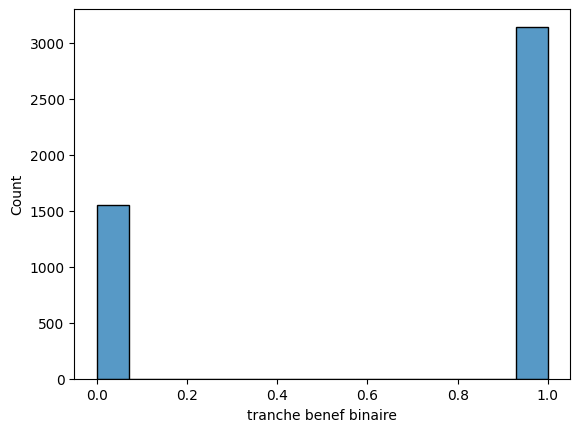

In [25]:
sns.histplot(data=df, x="tranche benef binaire")

In [26]:
df_0 = df[df['tranche benef binaire'] == 0]
df3 = pd.concat([df, df_0], ignore_index=True)

<AxesSubplot: xlabel='tranche benef binaire', ylabel='Count'>

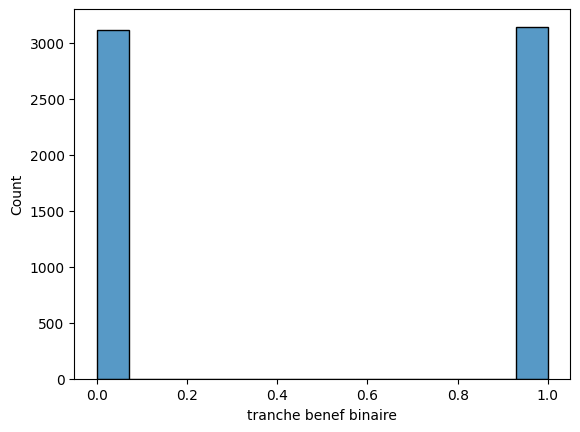

In [27]:
sns.histplot(data=df3, x="tranche benef binaire")

In [28]:
def X_and_Y(df):
    X = df.drop(columns = ['tranche benef', 'benefice global', 'tranche benef binaire'])
    Y = df['tranche benef']
    Y_bin = df['tranche benef binaire']
    return X, Y, Y_bin

In [29]:
def train_test(df):
    X, Y, Y_bin = X_and_Y(df)
    TRAINING_SET_RATIO = 0.9    
    ind = [i for i in range(df.shape[0])]
    random.seed(4)
    random.shuffle(ind)
    X_train=X.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    Y_train=Y.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    Y_bin_train=Y_bin.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    X_test=X.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    Y_test=Y.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    Y_bin_test=Y_bin.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    return X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test

In [30]:
def Random_search_XGBoost(df):
        X, Y, Y_bin = X_and_Y(df)
        # A parameter grid for XGBoost
        params = {
                'min_child_weight': [1, 5, 10],
                'gamma': [0.5, 1, 1.5, 2, 5],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'max_depth': [3, 4, 5]
                }

        xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

        folds = 3
        param_comb = 5

        skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

        random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y_bin), verbose=3, random_state=1001 )

        random_search.fit(X, Y_bin)

        return random_search

def print_Random_search_XGBoost(df):
        random_search = Random_search_XGBoost(df)
        folds = 3
        param_comb = 5
        print('\n Best estimator:')
        print(random_search.best_estimator_)
        print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
        print(random_search.best_score_ * 2 - 1)
        print('\n Best hyperparameters:')
        print(random_search.best_params_)
        
        return random_search.best_estimator_

In [31]:
xgb = print_Random_search_XGBoost(df)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[17:48:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto', ...)

 Best normalized gini

In [32]:
def scores_XGBoost(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    xgb = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=600, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto')
    xgb.fit(X_train, Y_bin_train)
    Y_pred_test = xgb.predict(X_test)
    print(confusion_matrix(Y_bin_test, Y_pred_test, labels=[0,1]))
    print(classification_report(Y_bin_test, Y_pred_test, digits = 4))

In [33]:
scores_XGBoost(df)

[[ 50 100]
 [ 37 283]]
              precision    recall  f1-score   support

           0     0.5747    0.3333    0.4219       150
           1     0.7389    0.8844    0.8051       320

    accuracy                         0.7085       470
   macro avg     0.6568    0.6089    0.6135       470
weighted avg     0.6865    0.7085    0.6828       470



In [34]:
scores_XGBoost(df3)

[[200 102]
 [109 214]]
              precision    recall  f1-score   support

           0     0.6472    0.6623    0.6547       302
           1     0.6772    0.6625    0.6698       323

    accuracy                         0.6624       625
   macro avg     0.6622    0.6624    0.6622       625
weighted avg     0.6627    0.6624    0.6625       625



In [35]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [36]:
def Grid_search_Random_Forest_bin(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    n_estimators = [100]
    max_features = ['auto']
    max_depth = [2, 3, 5]
    max_depth.append(None)
    min_samples_split = [2, 5]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True]

    params_grid = {'n_estimators': n_estimators, 'max_features': max_features,
                'max_depth': max_depth, 'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

    rf_clf = RandomForestClassifier(random_state=42)

    rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=3, verbose=2, n_jobs=-1)


    rf_cv.fit(X_train, Y_bin_train)
    best_params = rf_cv.best_params_
    print(f"Best parameters: {best_params}")

    rf_clf = RandomForestClassifier(**best_params)
    rf_clf.fit(X_train, Y_bin_train)

    print_score(rf_clf, X_train, Y_bin_train, X_test, Y_bin_test, train=True)
    print_score(rf_clf, X_train, Y_bin_train, X_test, Y_bin_test, train=False)

In [37]:
Grid_search_Random_Forest_bin(df)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train Result:
Accuracy Score: 95.69%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.987241     0.944127  0.956923     0.965684      0.958454
recall        0.881766     0.994328  0.956923     0.938047      0.956923
f1-score      0.931527     0.968577  0.956923     0.950052      0.956265
support    1404.000000  2821.000000  0.956923  4225.000000   4225.000000
_______________________________________________
Confusion Matrix: 
 [[1238  166]
 [  16 2805]]

Test Result:
Accuracy Score: 68.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.521739    0.715711  0.687234    0.618725      0.653805
recall       0.240000    0.896875  0.687234    0.568437      0.687234
f1-score     0.328767    0.796117  0.687234    0.562442      0.646962
support    150.000000  320.000000  0.687234 

In [38]:
Grid_search_Random_Forest_bin(df1)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train Result:
Accuracy Score: 98.60%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.992035     0.983160  0.985997     0.987598      0.986076
recall        0.965131     0.996208  0.985997     0.980670      0.985997
f1-score      0.978398     0.989641  0.985997     0.984020      0.985947
support    2323.000000  4747.000000  0.985997  7070.000000   7070.000000
_______________________________________________
Confusion Matrix: 
 [[2242   81]
 [  18 4729]]

Test Result:
Accuracy Score: 70.61%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.585987    0.736089  0.706107    0.661038      0.686819
recall       0.356589    0.876894  0.706107    0.616742      0.706107
f1-score     0.443373    0.800346  0.706107    0.621860      0.683172
support    258.000000  528.000000  0.706107 

In [39]:
Grid_search_Random_Forest_bin(df3)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    2806.0  2818.0       1.0     5624.0        5624.0
_______________________________________________
Confusion Matrix: 
 [[2806    0]
 [   0 2818]]

Test Result:
Accuracy Score: 85.28%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.793296    0.932584    0.8528    0.862940      0.865280
recall       0.940397    0.770898    0.8528    0.855648      0.852800
f1-score     0.860606    0.844068    0.8528    0.852337      0.852059
support    302.000000  323.000000    0.8528  625.000000    625.000000
_________________________________

In [40]:
def Grid_search_Random_Forest(df):
    X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(df)
    n_estimators = [100]
    max_features = ['auto']
    max_depth = [2, 3, 5]
    max_depth.append(None)
    min_samples_split = [2, 5]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True]

    params_grid = {'n_estimators': n_estimators, 'max_features': max_features,
                'max_depth': max_depth, 'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

    rf_clf = RandomForestClassifier(random_state=42)

    rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=3, verbose=2, n_jobs=-1)


    rf_cv.fit(X_train, Y_train)
    best_params = rf_cv.best_params_
    print(f"Best parameters: {best_params}")

    rf_clf = RandomForestClassifier(**best_params)
    rf_clf.fit(X_train, Y_train)

    print_score(rf_clf, X_train, Y_train, X_test, Y_test, train=True)
    print_score(rf_clf, X_train, Y_train, X_test, Y_test, train=False)

In [41]:
Grid_search_Random_Forest(df)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train Result:
Accuracy Score: 85.37%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2            3  accuracy  \
precision     0.762903     0.930481     0.896373     0.853456  0.853728   
recall        0.894986     0.821530     0.817580     0.881066  0.853728   
f1-score      0.823683     0.872618     0.855166     0.867041  0.853728   
support    1057.000000  1059.000000  1058.000000  1051.000000  0.853728   

             macro avg  weighted avg  
precision     0.860803      0.860855  
recall        0.853790      0.853728  
f1-score      0.854627      0.854618  
support    4225.000000   4225.000000  
_______________________________________________
Confusion Matrix: 
 [[946  25  39  47]
 [103 870  38  48]
 [111  18 865  64]
 [ 80  22  23 926]]

Test Result:
Accuracy Score: 37.23%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2           3  accuracy 

In [42]:
Grid_search_Random_Forest(df1)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train Result:
Accuracy Score: 93.93%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2            3  accuracy  \
precision     0.893270     0.935447     0.970816     0.963436  0.939321   
recall        0.959345     0.945080     0.915216     0.937853  0.939321   
f1-score      0.925129     0.940239     0.942197     0.950472  0.939321   
support    1771.000000  1748.000000  1781.000000  1770.000000  0.939321   

             macro avg  weighted avg  
precision     0.940742      0.940799  
recall        0.939374      0.939321  
f1-score      0.939509      0.939509  
support    7070.000000   7070.000000  
_______________________________________________
Confusion Matrix: 
 [[1699   36   14   22]
 [  62 1652   15   19]
 [  84   45 1630   22]
 [  57   33   20 1660]]

Test Result:
Accuracy Score: 44.91%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2       